In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import output_processing as op
from functools import reduce
import prompts

/Users/ab-purushothama-macbook/.conda/envs/prej-prompt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
models= [
   "meta-llama/Llama-3.2-1B",
    "meta-llama/Llama-3.2-1B-Instruct",
    "meta-llama/Llama-3.2-3B",
    "meta-llama/Llama-3.2-3B-Instruct",
    "meta-llama/Llama-3.1-8B",
    "meta-llama/Llama-3.1-8B-Instruct",
    # "gpt2-medium",
    "gpt2-large",
    # "gpt2-xl",
    # "allenai/OLMo-2-0425-1B",
    # "allenai/OLMo-2-0425-1B-Instruct",
    # "allenai/OLMo-2-1124-7B",
    # "allenai/OLMo-2-1124-7B-Instruct",
    # "ministral/Ministral-3b-instruct",
    # "ministral/Ministral-4b-instruct",
    "mistralai/Ministral-8B-Instruct-2410",
    # "google/gemma-3-1b-it",
    # "google/gemma-3-4b-it",
    # "google/gemma-7b-it"
]
def read_and_organize_model_results(model_name):
    model_results = pd.read_csv(f"runs/runs-1001-05_19/{model_name}-results.csv")
    model_results.replace([0.0], -65504, inplace=True)
    model_results = op.organize_distribution(model_results)
    model_results["model_name"] = model_name.split("/")[-1]
    return model_results
    
combined_results = [read_and_organize_model_results(model_name) for model_name in models]
combined_df = pd.concat(combined_results).reset_index()
combined_df.shape

(9936, 22)

# Analysis with Answer Choice

In [3]:
np.sum(combined_df["Aff_prob"] > combined_df["UnAff_prob"])/combined_df.shape[0]

np.float64(0.5341183574879227)

In [4]:
combined_df.sample()

,index,title,prompt_type,prompt,version,output,output_text,cum_logprob,Yes_probs,No_probs,...,Other_prob,Aff_prob,UnAff_prob,Covered_prob,NotCovered_prob,Covered,NotCovered,Answer,entropy,model_name
1843,601,House Removal II,agreement_negation,"Harper's insurance covers damage from ""House R...",unambiguous_covered,No,"No\n If the movers were not professional, ...",NaN,0.267922,0.470218,...,0.26186,0.470218,0.267922,0.637031,0.362969,True,False,Covered,1.058554,Llama-3.2-1B-Instruct


In [5]:
combined_df.groupby(['prompt_type'], as_index=False, sort=False).apply(lambda x: x.Covered.sum()) 

/var/folders/9g/y4xr1pr156905g16w5kjh4qh0000gn/T/ipykernel_34347/3110038544.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df.groupby(['prompt_type'], as_index=False, sort=False).apply(lambda x: x.Covered.sum())


,prompt_type,None
0,yes_or_no,678
1,no_or_yes,369
2,negation,330
3,agreement,910
4,agreement_negation,778
5,disagreement,413
6,disagreement_negation,358
7,options,559
8,options_flipped,912


In [6]:
combined_df.sample().Covered

5396    True
Name: Covered, dtype: bool

# Percentage answer as 'Covered'

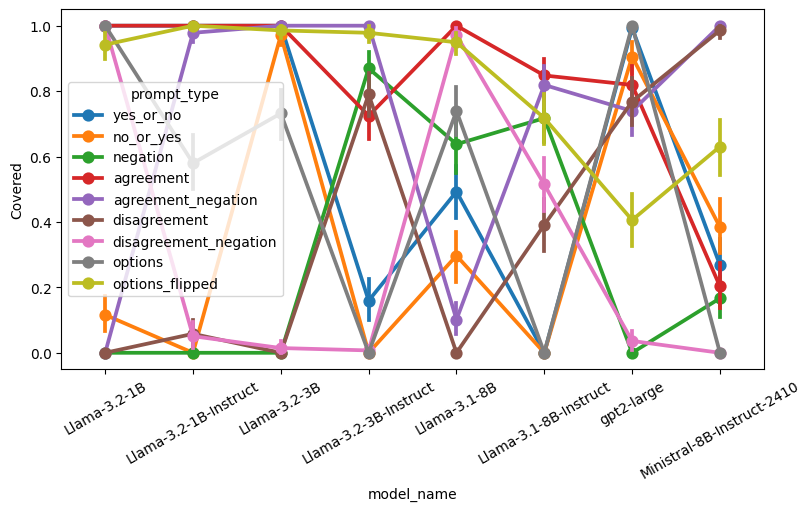

In [7]:
VAGUE_CONTRACTS_SIZE=138
fig, ax = plt.subplots(1,1, figsize=(8,5), layout='constrained')
plt.xticks(rotation=30)
point_plot = sns.pointplot(
    data = combined_df,
    x='model_name',
    y='Covered',
    hue='prompt_type',
)
# fig = point_plot.get_figure()
# fig.savefig("fig-covered-count-models.pdf", format="pdf")

## Answer 'covered' by prompt type

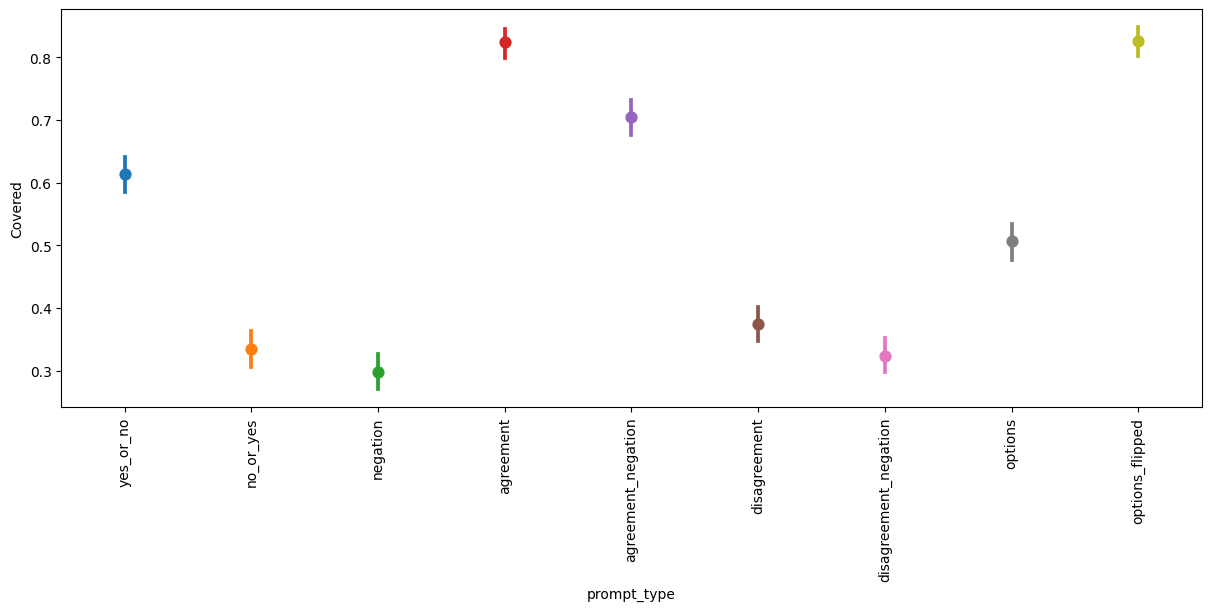

In [8]:
fig, ax = plt.subplots(1,1, figsize=(12,6), layout='constrained')
plt.xticks(rotation=90)
# plt.set_ylim((0, 138))
point_plot = sns.pointplot(
    data = combined_df,
    x='prompt_type',
    y='Covered',
    hue='prompt_type',
    linestyle="None"
)
# fig = point_plot.get_figure()
# fig.savefig("fig-covered-by-model-and-prompts.pdf", format="pdf")

## 'Covered' by item (totally on all models) [Not very useful]

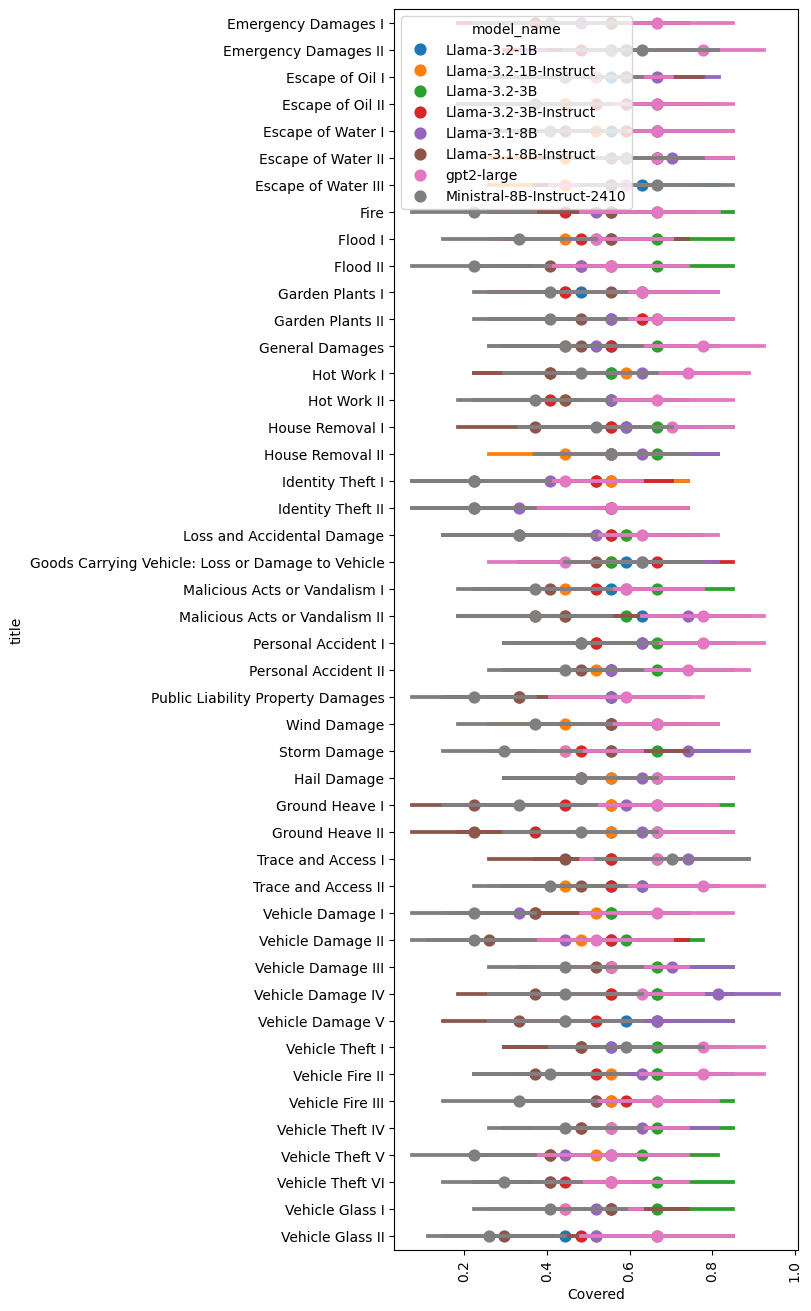

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8,13), layout='constrained')
plt.xticks(rotation=90)
# plt.set_ylim((0, 138))
point_plot = sns.pointplot(
    data = combined_df,
    x='Covered',
    y='title',
    hue='model_name',
    linestyle="None",
    # dodge=.8 - .8 / 8
)

## Covered by item (two models only) [Just a bit more useful]

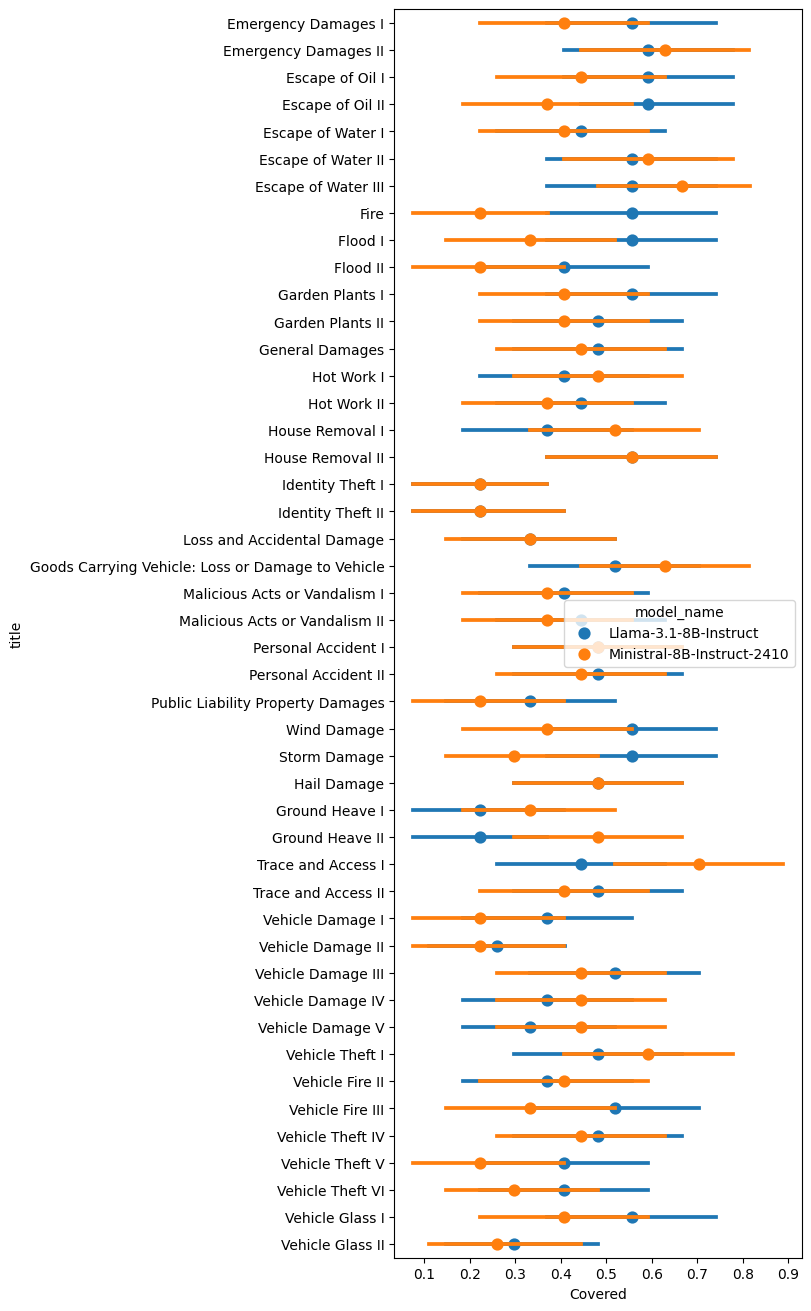

In [10]:
selected_models = ["Ministral-8B-Instruct-2410", "Llama-3.1-8B-Instruct"]
selected_df = combined_df[combined_df["model_name"].isin(selected_models)]

fig, ax = plt.subplots(1,1, figsize=(8,13), layout='constrained')
point_plot = sns.pointplot(
    data = selected_df,
    x='Covered',
    y='title',
    hue='model_name',
    linestyle="None",
)

# Analysis with relative measures

In [11]:
relative_measures = op.calculate_relative_measures(combined_df)
relative_measures.js_dist.unique()

array([0.05296124, 0.08719652, 0.34957016, ..., 0.04590675, 0.33515636,
       0.23093642])

# Jennsen Shannon Distance

## Model wise distances by prompt type

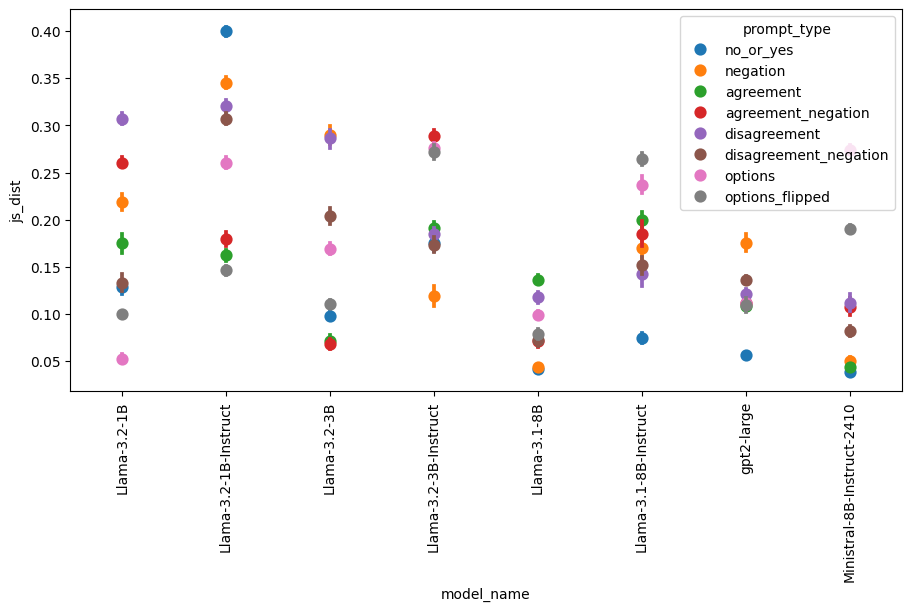

In [12]:
fig, ax = plt.subplots(1,1, figsize=(9,6), layout='constrained')
plt.xticks(rotation=90)
dist_plot_for_models = sns.pointplot(
    data=relative_measures, x='model_name', y ='js_dist', hue='prompt_type', linestyle='None')

## Distance variance by prompt type

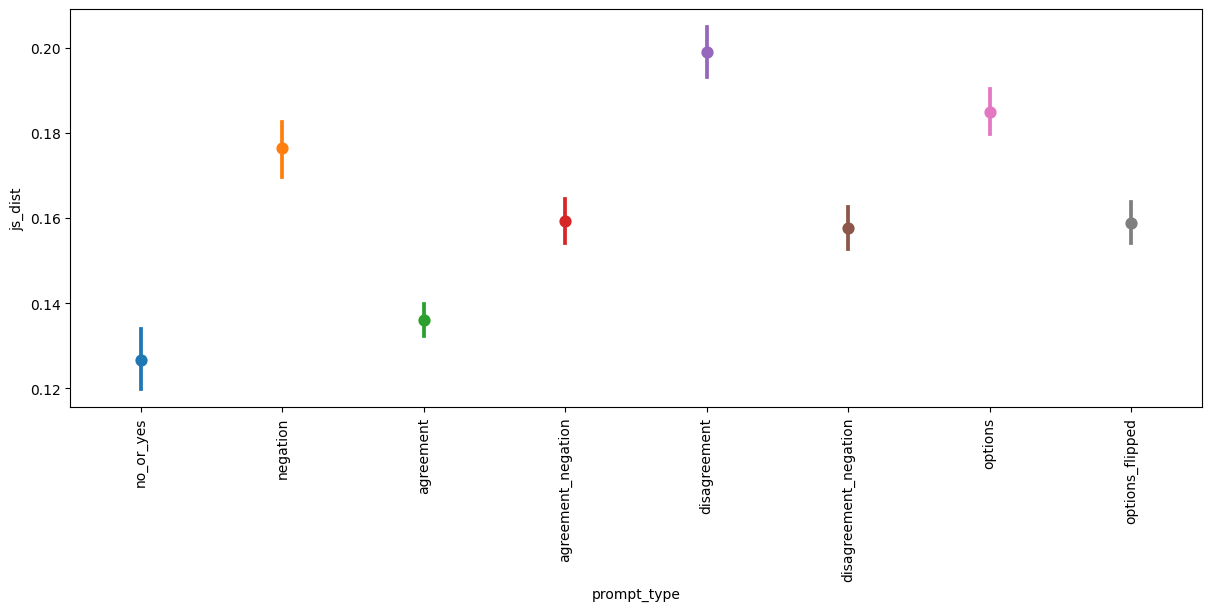

In [13]:
fig, ax = plt.subplots(1,1, figsize=(12,6), layout='constrained')
plt.xticks(rotation=90)
# plt.set_ylim((0, 138))
point_plot = sns.pointplot(
    data = relative_measures,
    x='prompt_type',
    y='js_dist',
    hue='prompt_type',
    linestyle="None"
)
# fig = point_plot.get_figure()

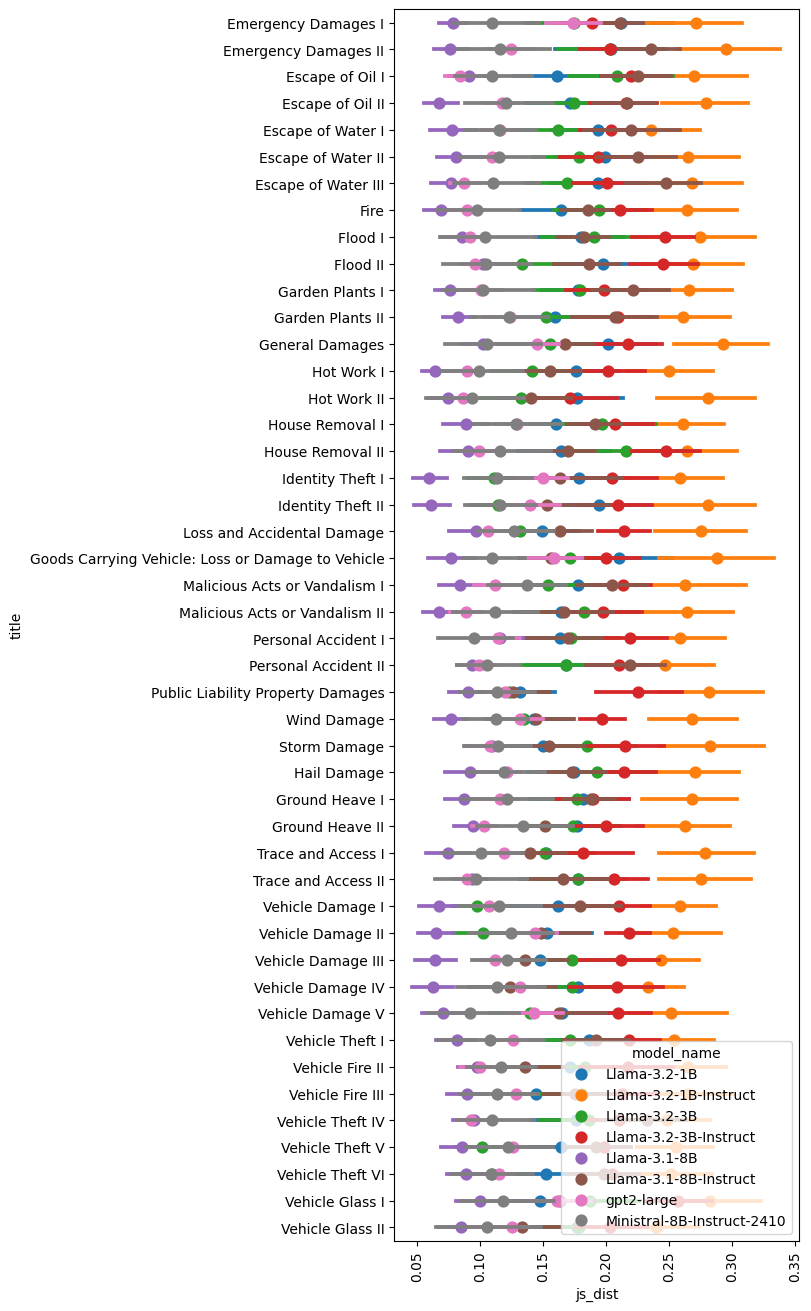

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8,13), layout='constrained')
plt.xticks(rotation=90)
# plt.set_ylim((0, 138))
point_plot = sns.pointplot(
    data = relative_measures,
    x='js_dist',
    y='title',
    hue='model_name',
    linestyle="None",
    # dodge=.8 - .8 / 8
)

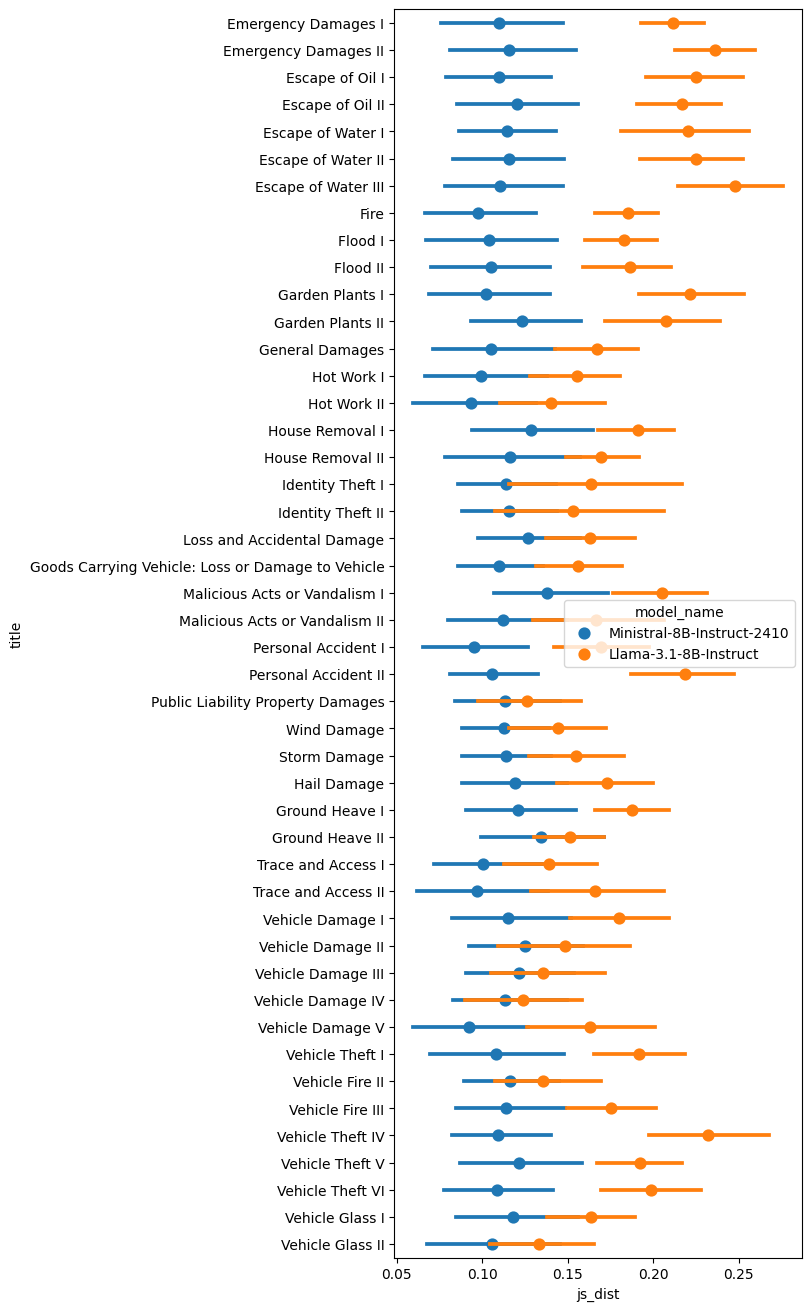

In [15]:
selected_models = ["Ministral-8B-Instruct-2410", "Llama-3.1-8B-Instruct"]
selected_df = relative_measures[relative_measures["model_name"].isin(selected_models)]

fig, ax = plt.subplots(1,1, figsize=(8,13), layout='constrained')
point_plot = sns.pointplot(
    data = selected_df,
    x='js_dist',
    y='title',
    hue='model_name',
     hue_order=selected_models,
    linestyle="None",
)

# Conditional Entropy

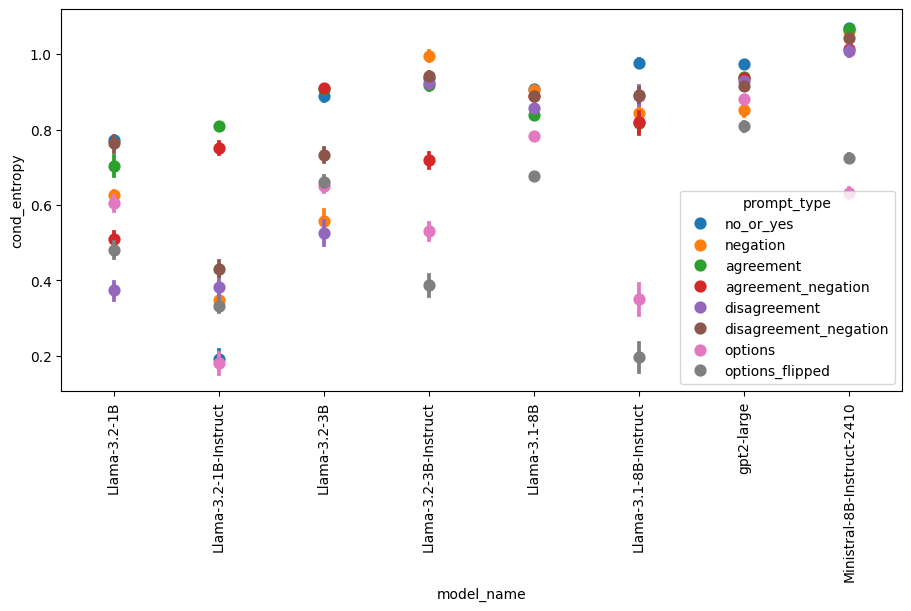

In [16]:
fig, ax = plt.subplots(1,1, figsize=(9,6), layout='constrained')
plt.xticks(rotation=90)
dist_plot_for_models = sns.pointplot(
    data=relative_measures, x='model_name', y ='cond_entropy', hue='prompt_type', linestyle='None')

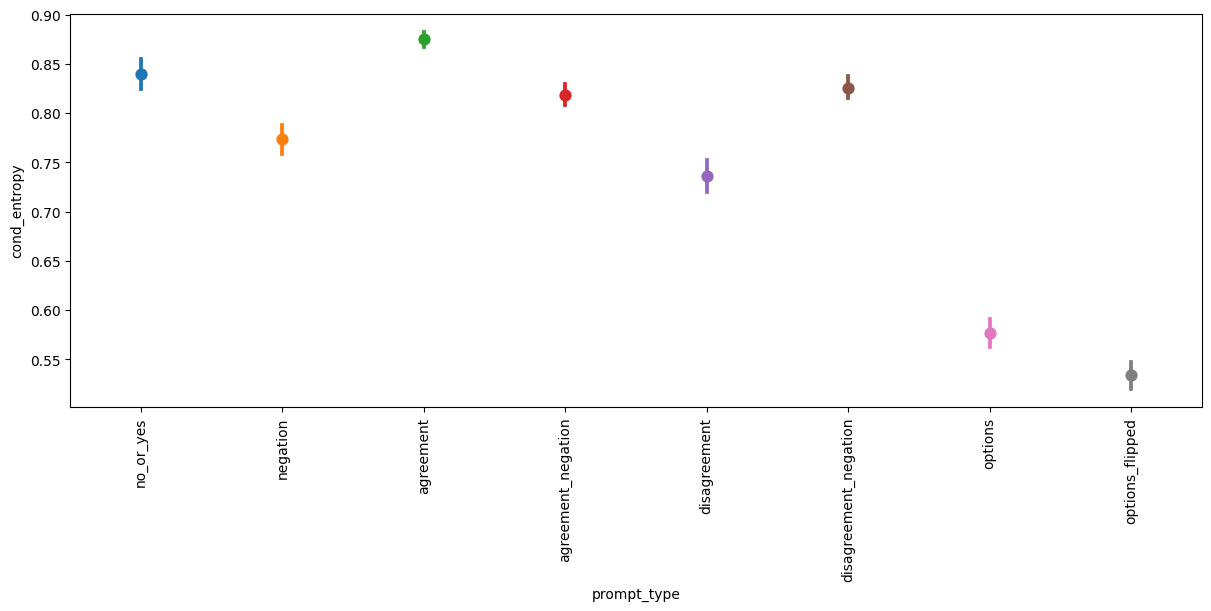

In [17]:
fig, ax = plt.subplots(1,1, figsize=(12,6), layout='constrained')
plt.xticks(rotation=90)
# plt.set_ylim((0, 138))
point_plot = sns.pointplot(
    data = relative_measures,
    x='prompt_type',
    y='cond_entropy',
    hue='prompt_type',
    linestyle="None"
)
# fig = point_plot.get_figure()

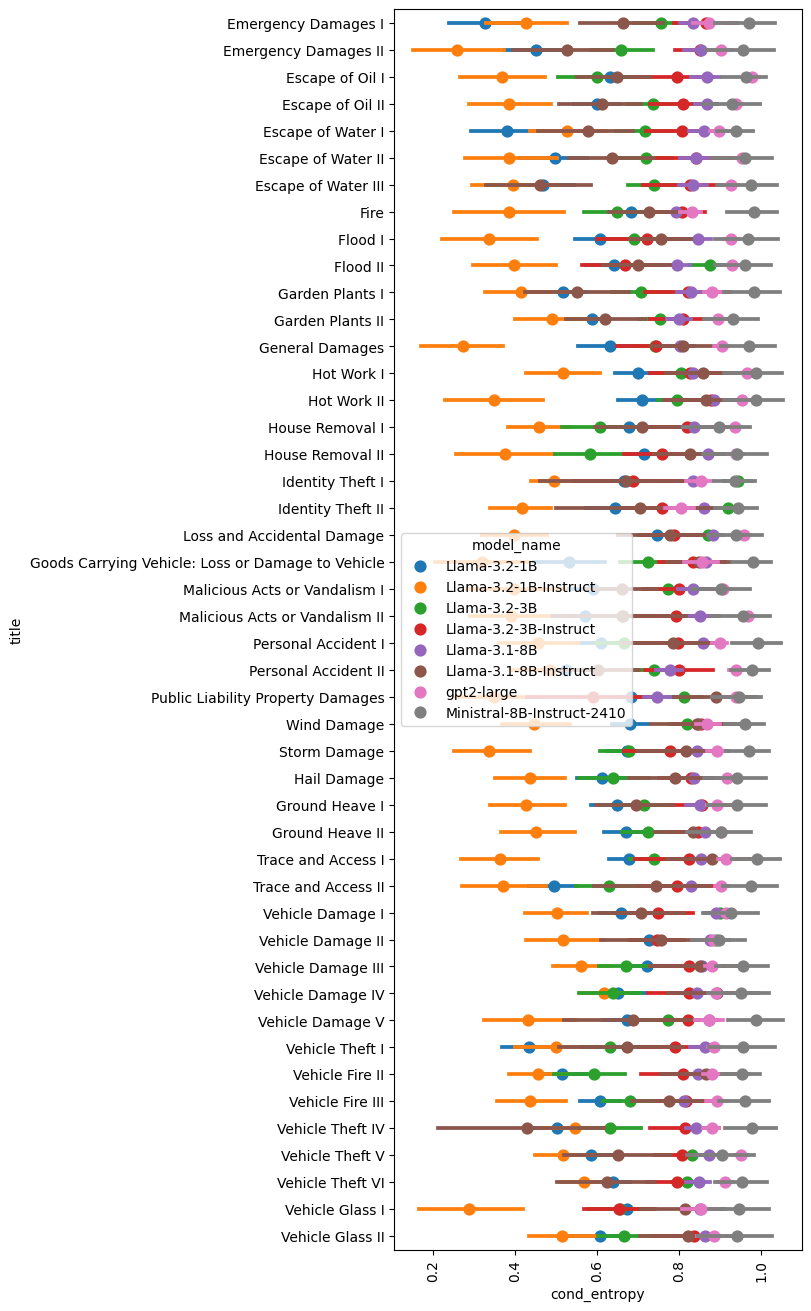

In [18]:
fig, ax = plt.subplots(1,1, figsize=(8,13), layout='constrained')
plt.xticks(rotation=90)
# plt.set_ylim((0, 138))
point_plot = sns.pointplot(
    data = relative_measures,
    x='cond_entropy',
    y='title',
    hue='model_name',
    linestyle="None",
    # dodge=.8 - .8 / 8
)

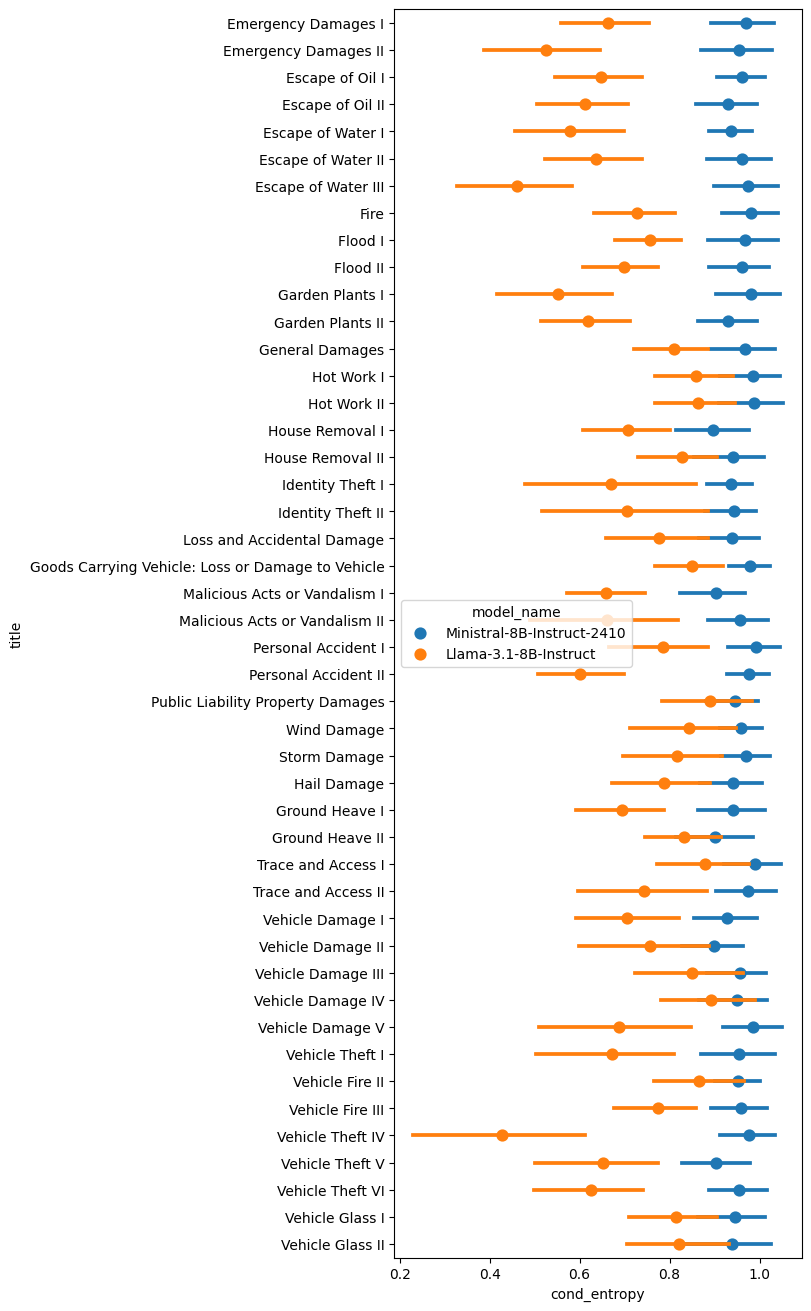

In [19]:
selected_models = ["Ministral-8B-Instruct-2410", "Llama-3.1-8B-Instruct"]
selected_df = relative_measures[relative_measures["model_name"].isin(selected_models)]

fig, ax = plt.subplots(1,1, figsize=(8,13), layout='constrained')
point_plot = sns.pointplot(
    data = selected_df,
    x='cond_entropy',
    y='title',
    hue='model_name',
    hue_order=selected_models,
    linestyle="None",
)

# Item wise Majority Votes

In [20]:
reversal_sums = relative_measures.groupby(['model_name', 'prompt_type'], as_index=False, sort=False).agg({"more_than_reversal": "sum"})
reversal_sums.groupby('model_name', as_index=False, sort=False).agg({"more_than_reversal": 'sum'})

,model_name,more_than_reversal
0,Llama-3.2-1B,460.0
1,Llama-3.2-1B-Instruct,17.0
2,Llama-3.2-3B,160.0
3,Llama-3.2-3B-Instruct,838.0
4,Llama-3.1-8B,944.0
5,Llama-3.1-8B-Instruct,199.0
6,gpt2-large,350.0
7,Ministral-8B-Instruct-2410,557.0


In [21]:
relative_measures.groupby(['model_name'], as_index=False, sort=False).agg({"js_dist": "mean"})

,model_name,js_dist
0,Llama-3.2-1B,0.172040
1,Llama-3.2-1B-Instruct,0.265191
2,Llama-3.2-3B,0.162331
3,Llama-3.2-3B-Instruct,0.210090
4,Llama-3.1-8B,0.082755
5,Llama-3.1-8B-Instruct,0.178282
6,gpt2-large,0.116326
7,Ministral-8B-Instruct-2410,0.112265


In [22]:
reversal_sums.groupby('prompt_type', as_index=False, sort=False).agg({"more_than_reversal": 'sum'})

,prompt_type,more_than_reversal
0,no_or_yes,247.0
1,negation,513.0
2,agreement,404.0
3,agreement_negation,466.0
4,disagreement,540.0
5,disagreement_negation,386.0
6,options,507.0
7,options_flipped,462.0


In [23]:
(reversal_sums.pivot(index="model_name", columns="prompt_type").round(2))

more_than_reversal                                  \
prompt_type                         agreement agreement_negation disagreement   
model_name                                                                      
Llama-3.1-8B                            137.0              113.0        133.0   
Llama-3.1-8B-Instruct                    39.0               14.0          1.0   
Llama-3.2-1B                             56.0              112.0        132.0   
Llama-3.2-1B-Instruct                     0.0                0.0          0.0   
Llama-3.2-3B                              4.0                1.0         68.0   
Llama-3.2-3B-Instruct                   105.0              132.0        101.0   
Ministral-8B-Instruct-2410               38.0               76.0         72.0   
gpt2-large                               25.0               18.0         33.0   

                                                                             \
prompt_type                disagreement_negation negation no_or_yes options   
model_name                                                                    
Llama-3.1-8B                               114.0    100.0      95.0   131.0   
Llama-3.1-8B-Instruct                        8.0      3.0       4.0    60.0   
Llama-3.2-1B                                37.0    107.0       2.0     5.0   
Llama-3.2-1B-Instruct                        0.0      0.0      17.0     0.0   
Llama-3.2-3B                                 6.0     71.0       0.0     9.0   
Llama-3.2-3B-Instruct                       89.0     60.0      92.0   129.0   
Ministral-8B-Instruct-2410                  67.0     34.0      31.0   135.0   
gpt2-large                                  65.0    138.0       6.0    38.0   

                                            
prompt_type                options_flipped  
model_name                                  
Llama-3.1-8B                         121.0  
Llama-3.1-8B-Instruct                 70.0  
Llama-3.2-1B                           9.0  
Llama-3.2-1B-Instruct                  0.0  
Llama-3.2-3B                           1.0  
Llama-3.2-3B-Instruct                130.0  
Ministral-8B-Instruct-2410           104.0  
gpt2-large                            27.0

# Majority Votes (per-title, per-model)

In [53]:
combined_df

title                version                  model_name  \
                                                                                
0      Emergency Damages I  unambiguous_uncovered                Llama-3.2-1B   
1      Emergency Damages I    unambiguous_covered                Llama-3.2-1B   
2      Emergency Damages I          controversial                Llama-3.2-1B   
3     Emergency Damages II  unambiguous_uncovered                Llama-3.2-1B   
4     Emergency Damages II    unambiguous_covered                Llama-3.2-1B   
...                    ...                    ...                         ...   
1099       Vehicle Glass I    unambiguous_covered  Ministral-8B-Instruct-2410   
1100       Vehicle Glass I          controversial  Ministral-8B-Instruct-2410   
1101      Vehicle Glass II  unambiguous_uncovered  Ministral-8B-Instruct-2410   
1102      Vehicle Glass II    unambiguous_covered  Ministral-8B-Instruct-2410   
1103      Vehicle Glass II          controversial  Ministral-8B-Instruct-2410   

          Answer             
            mode <lambda_0>  
0        Covered   0.555556  
1        Covered   0.555556  
2        Covered   0.555556  
3        Covered   0.555556  
4        Covered   0.555556  
...          ...        ...  
1099  NotCovered   0.666667  
1100  NotCovered   0.555556  
1101  NotCovered   0.777778  
1102  NotCovered   0.666667  
1103  NotCovered   0.777778  

[1104 rows x 5 columns]

# 